# 1. DNN
## Feature Engineering
- 1. 이상치 제거
- 2. 로그변환
- 3. MInMaxScaler() : Standard Scailing보다 성능이 좋음
- 4. PCA => 추가 : 성능 0.05정도 향상
- 5. Shap
- 6. LR + Ridge의 select P


### Modeling Test
1. Regularization
    - L1, L2, L1_L2  
    - 0.001, 0.005, 0.01, 0.05 
    - batch_size 16,32,64의 조합 => 총 48가지 파라미터 + 모델 1~13까지 모두 돌려보며 최적의 파라미터 찾기

    => L2 Regularization에서 0.05일 때 64의 batch_size가 최적

2. Opt
    - Opt 'adam', 'nadam' 체크
    - Adam : 0.7539 => 채택
    - Nadam : 0.7507
3. 20개의 모델 5회 반복 => 100개의 pred 중 0.759를 넘기는 pred의 gmean

##### 개선중 : 하드코딩으로 가장 최적의 파라미터를 찾을 예정입니다.


----
# 2.DAE + DNN
## Modeling
수정예정 : Dimmension 설정, 파라미터 튜닝

### Feature Engineering
- 1. 이상치 제거
- 2. 로그변환
- 3. MinMaxScaler()
- 4. PCA
- DAE:
    - 에포크 조절 : by loss

# Library

In [2]:
# basic 

import pandas as pd
import numpy as np
import datetime, time
import datetime as dt
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50, 'display.max_rows', 200)


# plot

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


# models
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.ensemble import AdaBoostClassifier
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.ensemble import VotingClassifier
from vecstack import StackingTransformer
from vecstack import stacking
from sklearn.metrics import roc_curve, auc

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
import shap

import random

# 1. DNN

## Reading Data

In [14]:
X_data = pd.read_csv('X_data1.csv')

## Feature Engineering

### 이상치제거

In [15]:
X_data.iloc[:,1:] = X_data.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

### 로그변환

In [16]:
X_data.iloc[:,1:] = np.log1p(X_data.iloc[:,1:])

### shap

In [17]:
X_train = X_data.iloc[:3500,1:]
X_test = X_data.iloc[3500:,1:]
y_train = pd.read_csv('Data/y_train.csv')['gender']

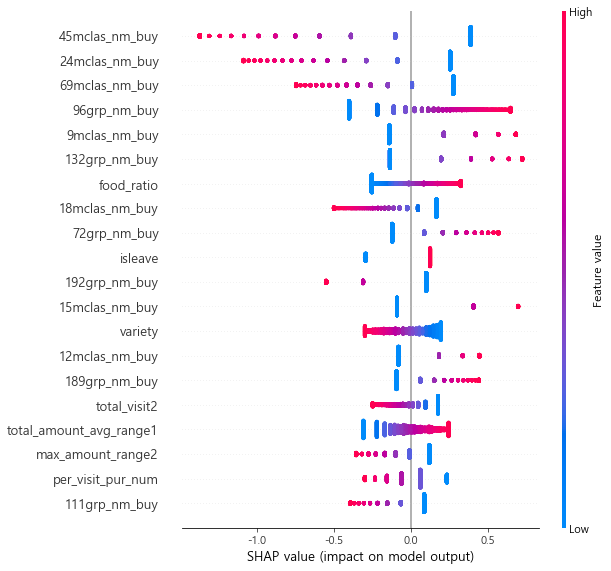

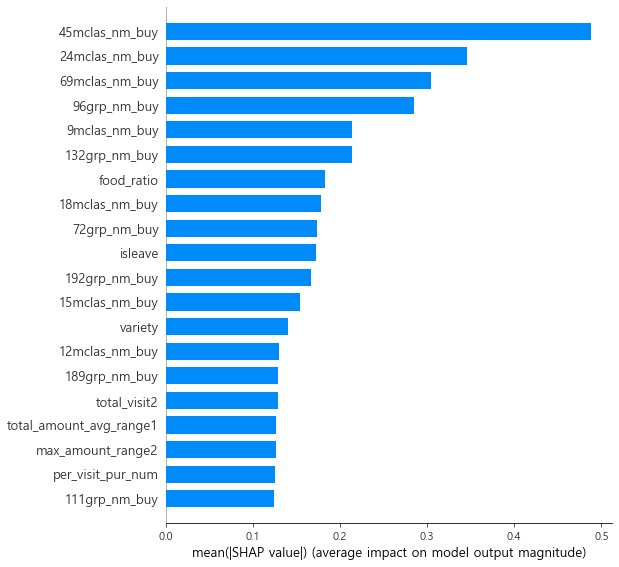

,column_name,shap_importance
1215,45mclas_nm_buy,0.487911
1208,24mclas_nm_buy,0.346227
1223,69mclas_nm_buy,0.303903
1136,96grp_nm_buy,0.284973
1203,9mclas_nm_buy,0.21369
...,...,...
652,170116_buy,0
651,165162_buy,0
650,164105_buy,0
649,164101_buy,0


In [18]:
X_importance = X_test

# # Explain model predictions using shap library:
# model = XGBClassifier(random_state=0).fit(X_train, y_train)
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_importance)

model = LogisticRegression(random_state=0).fit(X_train, y_train)
explainer = shap.LinearExplainer(model, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_importance)
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

In [19]:
final_col = importance_df[importance_df.shap_importance>0].column_name
X_data = X_data.loc[:,final_col]

In [20]:
X_data.insert(loc=0,column='cust_id',value=range(0,5982))

### Scailing

In [21]:
scaler = MinMaxScaler()
X_data = scaler.fit_transform(X_data.iloc[:,1:])

In [23]:
scaler=MinMaxScaler()
# X_data = scaler.fit_transform(X_data.iloc[:,1:])

max_col = X_data.shape[1]
pca = PCA(n_components=max_col, random_state=0).fit(X_data)

cumsum = np.cumsum(pca.explained_variance_ratio_)
num_col = np.argmax(cumsum >= 0.99)

# num_col 이 1이었기 때문에 num_col은 max_col이 되었다

if num_col == 1:
    num_col = max_col -1

pca = PCA(n_components = num_col, random_state=0).fit_transform(X_data)

X_data = pd.DataFrame(pca)

X_data.insert(0,'cust_id',np.arange(5982))

### Feature Selecting

In [26]:
X_train = X_data[:3500]
X_test = X_data[3500:]
y_train = pd.read_csv('Data/y_train.csv')['gender']

### 6개의 모델을 이용해서 가장 잘나온 p를 뽑을 것임

In [12]:
from sklearn.linear_model import Ridge, Lasso

In [12]:
logreg = LogisticRegression(random_state=0, n_jobs=-1)
ridge = Ridge(random_state=0)

models = [logreg, ridge]

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [05:54<00:00,  3.73s/it]
No handles with labels found to put in legend.
  3%|██▌                                                                                | 3/95 [00:00<00:03, 24.06it/s]

LogisticRegression (20, 0.7483844362231317)


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:07<00:00, 11.97it/s]
No handles with labels found to put in legend.


Ridge (20, 0.7470944395900052)


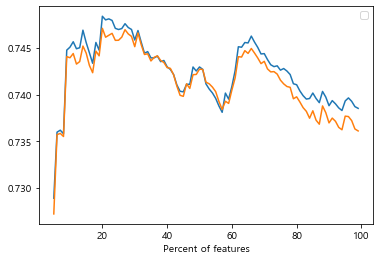

In [13]:
best_of_best = [0,0]
for model in models:
    
    cv_scores = []
    
    # 퍼센타일을 5~100프로 모두 살피기
    for percentile in tqdm(range(5,100)):
    
        X_new = SelectPercentile(percentile = percentile).fit_transform(X_train,y_train)
       
        # cross_val_score 5번의 평균값
        cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=5).mean()
        
        cv_scores.append((percentile, cv_score))
        
    # 베스트 percentile과 점수 출력
    best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
    print(model.__class__.__name__, best_score)
    
    # 모델별 percentile에 따른 성능 그림
    plt.plot([p for p,_ in cv_scores], [score for _, score in cv_scores])
    plt.xlabel('Percent of features')
    plt.legend(loc=0)
    plt.grid()
    if best_score[1] > best_of_best[1]:
        best_of_best = best_score

In [14]:
bf = best_of_best[0]

In [28]:
select_p = SelectPercentile(percentile= bf).fit(X_train, y_train)
X_train = pd.DataFrame(select_p.transform(X_train))
X_test = pd.DataFrame(select_p.transform(X_test))

*Modeling : batchsize, epoch, optimzer 조절

In [30]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,test_size = 0.3,  random_state=0) 

In [31]:
import tensorflow as tf
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model

Using TensorFlow backend.


In [32]:
def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

def D_model1(reg):
    model = Sequential()
    model.add(Dense(64, activation = 'relu', kernel_regularizer = reg,input_shape = (X_train.shape[1], )))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = "sigmoid"))
    return model

def D_model2(reg):
    model = Sequential()
    model.add(Dense(64, activation = 'relu', kernel_regularizer = reg,input_shape = (X_train.shape[1], )))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = "sigmoid"))
    return model

def D_model3(reg):
    model = Sequential()
    model.add(Dense(64, activation = 'relu', kernel_regularizer = reg,input_shape = (X_train.shape[1], )))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = "sigmoid"))
    return model

def D_model4(reg):
    model = Sequential()
    model.add(Dense(128, activation = 'relu', kernel_regularizer = reg,input_shape = (X_train.shape[1], )))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = "sigmoid"))
    return model

def D_model5(reg):
    model = Sequential()
    model.add(Dense(128, activation = 'relu', kernel_regularizer = reg,input_shape = (X_train.shape[1], )))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = "sigmoid"))
    return model

def D_model6(reg):
    model = Sequential()
    model.add(Dense(128, activation = 'relu', kernel_regularizer = reg,input_shape = (X_train.shape[1], )))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = "sigmoid"))
    return model

def D_model7(reg):
    model = Sequential()
    model.add(Dense(128, activation = 'relu', kernel_regularizer = reg,input_shape = (X_train.shape[1], )))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = "sigmoid"))
    return model

def D_model8(reg):
    model = Sequential()
    model.add(Dense(128, activation = 'relu', kernel_regularizer = reg,input_shape = (X_train.shape[1], )))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = "sigmoid"))
    return model

def D_model9(reg):
    model = Sequential()
    model.add(Dense(256, activation = 'relu', kernel_regularizer = reg,input_shape = (X_train.shape[1], )))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = "sigmoid"))
    return model

def D_model10(reg):
    model = Sequential()
    model.add(Dense(256, activation = 'relu', kernel_regularizer = reg,input_shape = (X_train.shape[1], )))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = "sigmoid"))
    return model

def D_model11(reg):
    model = Sequential()
    model.add(Dense(256, activation = 'relu', kernel_regularizer = reg,input_shape = (X_train.shape[1], )))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = "sigmoid"))
    return model

def D_model12(reg):
    model = Sequential()
    model.add(Dense(256, activation = 'relu', kernel_regularizer = reg,input_shape = (X_train.shape[1], )))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = "sigmoid"))
    return model

def D_model13(reg):
    model = Sequential()
    model.add(Dense(256, activation = 'relu', kernel_regularizer = reg,input_shape = (X_train.shape[1], )))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = "sigmoid"))
    return model

def D_model14(reg):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def D_model15(reg):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def D_model16(reg):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

def D_model17(reg):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

def D_model18(reg):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

def D_model19(reg):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

def D_model20(reg):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

#######################하드코딩 : 자는동안 실행 예정##############################3
def find_out(builded_model,best_score,batch_size, best_patience, best_opt, best_reg):    
    global aucs, preds, be_model
    best = 0
    try:
        SEED = np.random.randint(1, 10000)              
        random.seed(SEED)       
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        mc = ModelCheckpoint('best_model2.tf', monitor='val_auroc', mode='max', save_best_only=True)
        es = EarlyStopping(monitor='val_loss',patience=best_patience)
        model=builded_model(best_reg)
        model.compile(loss='binary_crossentropy', optimizer=best_opt,  metrics=[auroc])
        history = model.fit(X_tr, y_tr, validation_split=0.2, batch_size=batch_size, epochs=200, callbacks=[es,mc], shuffle=False, verbose=0)
        dependencies = {'auroc': auroc}
        nowbest_model = load_model('best_model2.tf', custom_objects=dependencies)
        auc = roc_auc_score(y_val,nowbest_model.predict_proba(X_val))
        aucs.append(auc)
        print('AUC', auc)
        preds.append(nowbest_model.predict(X_test).flatten())   
        if auc > best:
            best = auc
            be_model = nowbest_model
    except:
        pass
    return preds, aucs, be_model

def find_params():
    regs = []
    for reg_num in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]:
        for reg in [l1, l2, l1_l2]:
            regs.append(reg(reg_num))
    batch_sizes = [2**n for n in range(5,10)]
    patience_sizes = [x for x in range(2,9)]
    score = []
    best_aucs = []
    optimizers = [Adam(),Nadam()]
    for reg in regs:
        for opt in optimizers:
            for patience_size in tqdm(patience_sizes):
                for batch_size in batch_sizes:    
                    try:
                        aucs = []
                        for i in range(3):
                            SEED = np.random.randint(1, 10000)              
                            random.seed(SEED)       
                            np.random.seed(SEED)
                            tf.random.set_seed(SEED)
                            mc = ModelCheckpoint('best_model2.tf', monitor='val_auroc', mode='max', save_best_only=True)
                            es = EarlyStopping(monitor='val_loss',patience=patience_size)
                            model=D_model1(reg)
                            model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[auroc])
                            history = model.fit(X_tr, y_tr, validation_split=0.2, batch_size=batch_size, epochs=200, callbacks=[es,mc], shuffle=False, verbose=0)
                            dependencies = {'auroc': auroc}
                            nowbest_model = load_model('best_model2.tf', custom_objects=dependencies)
                            auc = roc_auc_score(y_val,nowbest_model.predict_proba(X_val))
                            aucs.append(auc)  
                        best_aucs.append([np.mean(aucs),batch_size,patience_size,opt,reg])
                    except:
                        pass
    batch_size = pd.DataFrame(best_aucs).sort_values(by=0).iloc[0,1]
    best_patience = pd.DataFrame(best_aucs).sort_values(by=0).iloc[0,2]
    best_opt = pd.DataFrame(best_aucs).sort_values(by=0).iloc[0,3]
    best_reg = pd.DataFrame(best_aucs).sort_values(by=0).iloc[0,4]
    return batch_size, best_patience, best_opt, best_reg

D_models_grp1 = [D_model1, D_model2, D_model3]
D_models_grp2 = [D_model4, D_model5, D_model6, D_model7, D_model8]
D_models_grp3 = [D_model9, D_model10, D_model11, D_model12, D_model13]
D_models_grp4 = [D_model14, D_model15, D_model16, D_model17, D_model18, D_model19, D_model20]

D_models = D_models_grp1 + D_models_grp2 + D_models_grp3 + D_models_grp4

batch_patience = find_params()

batch_size = batch_patience[0]
best_patience = batch_patience[1]
best_opt = batch_patience[2]
best_reg = batch_patience[3]
print(batch_size, best_patience, best_opt, best_reg)

In [34]:
D_models_grp1 = [D_model1, D_model2, D_model3]
D_models_grp2 = [D_model4, D_model5, D_model6, D_model7, D_model8]
D_models_grp3 = [D_model9, D_model10, D_model11, D_model12, D_model13]
D_models_grp4 = [D_model14, D_model15, D_model16, D_model17, D_model18, D_model19, D_model20]

D_models = D_models_grp1 + D_models_grp2 + D_models_grp3 + D_models_grp4

In [36]:
def find_out(builded_model):    
    global aucs, preds, be_model
    best = 0
    try:
        SEED = np.random.randint(1, 10000)              
        random.seed(SEED)       
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        mc = ModelCheckpoint('best_model2.tf', monitor='val_auroc', mode='max', save_best_only=True)
        es = EarlyStopping(monitor='val_loss',patience=3)
        model=builded_model(l2(0.05))
        model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[auroc])
        history = model.fit(X_tr, y_tr, validation_split=0.2, batch_size=64, epochs=200, callbacks=[es,mc], shuffle=False, verbose=0)
        dependencies = {'auroc': auroc}
        nowbest_model = load_model('best_model2.tf', custom_objects=dependencies)
        auc = roc_auc_score(y_val,nowbest_model.predict_proba(X_val))
        aucs.append(auc)
        print('AUC', auc)
        preds.append(nowbest_model.predict(X_test).flatten())   
        if auc > best:
            best = auc
            be_model = nowbest_model
    except:
        pass
    return preds, aucs, be_model

In [37]:
best_score = 0
aucs = []
preds = []
be_model = 0
N = 5
p = 3.5

for i in range(N):
    for D_model in D_models:
        try:
            result = find_out(D_model)
        except:
            pass

AUC 0.7633337378308235
AUC 0.7641127217070316
AUC 0.7643241042664047
AUC 0.761137707908448
AUC 0.7629970915325628
AUC 0.7641831825601559
AUC 0.7649504229608434
AUC 0.7605309616732104
AUC 0.7568121944249808
AUC 0.7616191904047978
AUC 0.7593448706456172
AUC 0.7662382907762828
AUC 0.7648369026974763
AUC 0.7613256035167795
AUC 0.7595484242213096
AUC 0.7542051428593798
AUC 0.7542286298104212
AUC 0.7592509228414515
AUC 0.7628013669405507
AUC 0.7576812116135144
AUC 0.7636664696372442
AUC 0.7637193152770875
AUC 0.761529157092472
AUC 0.7500870974434453
AUC 0.7621750482461119
AUC 0.760507474722169
AUC 0.7651774634875773
AUC 0.7661991458578804
AUC 0.7594857923518659
AUC 0.7649191070261213
AUC 0.7613373469923002
AUC 0.7622963974931594
AUC 0.7639718000007829
AUC 0.7530151373399462
AUC 0.7594035880232207
AUC 0.762288568509479
AUC 0.7612277412207734
AUC 0.7592430938577708
AUC 0.75696094511491
AUC 0.7522752983821406
AUC 0.7615761309945549
AUC 0.7632554479940187
AUC 0.7648329882056362
AUC 0.76231988444

In [38]:
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))   

50    0.767812
44    0.767773
84    0.767726
55    0.766978
90    0.766974
70    0.766959
95    0.766340
11    0.766238
27    0.766199
46    0.765698
61    0.765299
92    0.765295
86    0.765197
26    0.765177
45    0.764958
6     0.764950
29    0.764919
12    0.764837
42    0.764833
82    0.764410
2     0.764324
85    0.764295
5     0.764183
89    0.764168
49    0.764132
52    0.764128
62    0.764113
1     0.764113
32    0.763972
66    0.763890
21    0.763719
81    0.763713
20    0.763666
0     0.763334
41    0.763255
72    0.763208
87    0.763122
4     0.762997
47    0.762919
65    0.762868
67    0.762817
18    0.762801
43    0.762320
64    0.762304
31    0.762296
35    0.762289
60    0.762175
24    0.762175
83    0.762155
69    0.762058
76    0.762046
80    0.761784
9     0.761619
40    0.761576
22    0.761529
30    0.761337
13    0.761326
36    0.761228
3     0.761138
74    0.761063
73    0.761009
91    0.760731
78    0.760723
63    0.760680
7     0.760531
25    0.760507
93    0.75

In [41]:
# Power mean ensemble
THRESHOLD = 0.767  # Use only models whose AUC exceeds this value

pred = 0
n = 0
for i in range(len(aucs)):
    if aucs.iloc[i] > THRESHOLD:
        pred = pred + preds[i]**p 
        n += 1
pred = pred / n    
pred = pred**(1/p)

# Make a submission file
t = pd.Timestamp.now()
# fname = f"dae_p{p}n{n}_submit_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(range(3500,5982), name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv('홍재성#0_DNN.csv', index=False)
# print(f"'{fname}' is ready to submit.")

# 2. DAE

In [ ]:
def find_out(builded_model):    
    global aucs, preds, be_model
    best = 0
    try:
        SEED = np.random.randint(1, 10000)              
        random.seed(SEED)       
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        mc = ModelCheckpoint('best_model2.tf', monitor='val_auroc', mode='max', save_best_only=True)
        es = EarlyStopping(monitor='val_loss',patience=3)
        model=builded_model(l2(0.05))
        model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[auroc])
        history = model.fit(X_tr, y_tr, validation_split=0.2, batch_size=64, epochs=200, callbacks=[es,mc], shuffle=False, verbose=0)
        dependencies = {'auroc': auroc}
        nowbest_model = load_model('best_model2.tf', custom_objects=dependencies)
        auc = roc_auc_score(y_val,nowbest_model.predict_proba(X_val))
        aucs.append(auc)
        print('AUC', auc)
        preds.append(nowbest_model.predict(X_test).flatten())   
        if auc > best:
            best = auc
            be_model = nowbest_model
    except:
        pass
    return preds, aucs, be_model

## Reading Data

In [22]:
X_data = pd.read_csv('X_data1.csv')

## Feature Engineering

### 이상치제거

In [23]:
X_data.iloc[:,1:] = X_data.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

### PCA

In [ ]:
scaler=MinMaxScaler()
X_data = scaler.fit_transform(X_data.iloc[:,1:])

max_col = X_data.shape[1]
pca = PCA(n_components=max_col, random_state=0).fit(X_data)

cumsum = np.cumsum(pca.explained_variance_ratio_)
num_col = np.argmax(cumsum >= 0.99)

# num_col 이 1이었기 때문에 num_col은 max_col이 되었다

if num_col == 1:
    num_col = max_col -1

pca = PCA(n_components = num_col, random_state=0).fit_transform(X_data)

X_data = pd.DataFrame(pca)

X_data.insert(0,'cust_id',np.arange(5982))

## AE

In [24]:
train = X_data.iloc[:3500,1:]
test = X_data.iloc[3500:,1:]
y_train = pd.read_csv('y_train.csv')['gender']

Train on 3500 samples, validate on 3500 samples
Epoch 1/100
3500/3500 [==============================] - 2s 621us/step - loss: 33789789.0880 - val_loss: 15779636.9051
Epoch 2/100
3500/3500 [==============================] - 2s 569us/step - loss: 19290564.8251 - val_loss: 15271712.5063
Epoch 3/100
3500/3500 [==============================] - 2s 659us/step - loss: 16978234.1520 - val_loss: 15533579.5771
Epoch 4/100
3500/3500 [==============================] - 2s 638us/step - loss: 16153716.2931 - val_loss: 15525392.2720
Epoch 5/100
3500/3500 [==============================] - 2s 592us/step - loss: 15569038.1291 - val_loss: 15157397.2149
Epoch 6/100
3500/3500 [==============================] - 2s 608us/step - loss: 15495110.1806 - val_loss: 14484422.7337
Epoch 7/100
3500/3500 [==============================] - 3s 729us/step - loss: 14414118.5211 - val_loss: 15733192.6297
Epoch 8/100
3500/3500 [==============================] - 2s 609us/step - loss: 13771240.1314 - val_loss: 15575976.8834


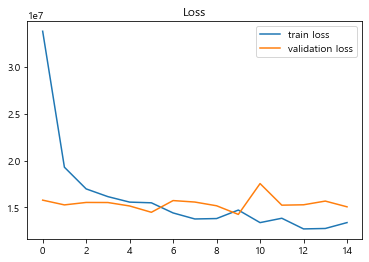

In [38]:
# Set hyper-parameters for power mean ensemble 
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):  
    X_train , X_test = train, test
    ##### STEP 1: Randomize Seed
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    ##### STEP 2: Build DAE #####
    
    # Define the encoder dimension
    encoding_dim = 128

    # Input Layer
    input_dim = Input(shape = (X_train.shape[1], ))

    # Encoder Layers
    noise = Dropout(0.5)(input_dim) # for Denoising
    encoded1 = Dense(512, activation = 'relu')(noise)
    encoded2 = Dense(256, activation = 'relu')(encoded1)
    encoded3 = Dense(128, activation = 'relu')(encoded2)
    encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)

    # Decoder Layers
    decoded1 = Dense(128, activation = 'relu')(encoded4)
    decoded2 = Dense(256, activation = 'relu')(decoded1)
    decoded3 = Dense(512, activation = 'relu')(decoded2)
    decoded4 = Dense(X_train.shape[1], activation = 'linear')(decoded3)

    # Combine Encoder and Deocder layers
    autoencoder = Model(inputs = input_dim, outputs = decoded4)

    # Compile the model
    autoencoder.compile(optimizer = 'adam', loss = 'mse')

    # Train the model
    history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=64, 
                              shuffle=True, validation_data=(X_test,X_test), verbose=0)

    ##### STEP 3: Reduce Dimension #####
        
    # Use a middle Bottleneck Layer to Reduce Dimension
    model = Model(inputs=input_dim, outputs=encoded4)
    X_train = model.predict(X_train)
    X_test = model.predict(X_test)

    ##### STEP 4: Build a DNN Model

    # Define the Model architecture
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.05)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Train the Model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[auroc])

    mc = ModelCheckpoint('best_model2.tf', monitor='val_auroc', mode='max', save_best_only=True)
    es = EarlyStopping(monitor='val_auroc',patience=3, mode = 'max')
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
    history = model.fit(train_x, train_y, epochs=100, batch_size=32, 
                        validation_data=(valid_x,valid_y),callbacks=[mc,es], verbose=0)
    nowbest_model = load_model('best_model2.tf', custom_objects=dependencies)
    dependencies = {'auroc': auroc}

    # Make Prediction
    auc = roc_auc_score(valid_y, nowbest_model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))     

In [39]:
# Power mean ensemble
THRESHOLD = 0.754  # Use only models whose AUC exceeds this value

pred = 0
n = 0
for i in range(N):
    if aucs.iloc[i] > THRESHOLD:
        pred = pred + preds[i]**p 
        n += 1
pred = pred / n    
pred = pred**(1/p)

# Make a submission file
t = pd.Timestamp.now()
# fname = f"dae_p{p}n{n}_submit_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(range(3500,5982), name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv('홍재성#0_DAE.csv', index=False)
# print(f"'{fname}' is ready to submit.")

In [40]:
pd.read_csv('홍재성#0_DAE')